In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # Not entirely sure how to import the raw .mat data

from mne_connectivity import spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity

mat_data = loadmat("Matlab Files/608_Depression_REST.mat")

In [5]:
eeg_signal = mat_data['EEG']['data'][0,0]

sampling_rate =  mat_data['EEG']['srate'][0,0][0,0]

chanlocs = mat_data['EEG']['chanlocs'][0,0]
channel_names = [str(chan[0]) for chan in chanlocs['labels'][0]]

In [11]:
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=['eeg']*59+['misc']+['eeg']*3+['misc']+['eog']*2+['ecg'])

In [13]:
info.set_montage("standard_1020", match_case=False, on_missing='warn')

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG, 2 misc, 2 EOG, 1 ECG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 500.0 Hz
>

In [15]:
raw = mne.io.RawArray(eeg_signal, info)

Creating RawArray with float64 data, n_channels=67, n_times=248480
    Range : 0 ... 248479 =      0.000 ...   496.958 secs
Ready.


In [19]:
raw.plot(scalings='auto')

Using qt as 2D backend.


In [21]:
epochs = mne.make_fixed_length_epochs(raw, duration=30, preload=True)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 15000 original time points ...
0 bad epochs dropped


In [31]:
min_freq = 0.1
max_freq = 50

Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}

# freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1)) # -> am not doing this many FOIs because it takes too long to compute
freqs = np.linspace(min_freq, max_freq, 5)


fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))]) # gets the min and max frequencies for each band defined in the dictionay
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])
# freqs = np.linspace(min_freq, max_freq, 5)

n_cycles = np.array([5]*104)

In [49]:
# OR con_time = spectral_connectivity_time(epochs, freqs, method='pli', mode='cwt_morlet', fmin, fmax, n_cycles=3, faverage=True)
con_time = spectral_connectivity_time(epochs.pick('eeg'), freqs=freqs, method='pli', mode='multitaper', n_cycles=freqs/2, faverage=True)

Replacing existing metadata with 3 columns
Fmin was not specified. Using fmin=min(freqs)
Fmax was not specified. Using fmax=max(freqs).
only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 16 ...
   Processing epoch 2 / 16 ...
   Processing epoch 3 / 16 ...
   Processing epoch 4 / 16 ...
   Processing epoch 5 / 16 ...
   Processing epoch 6 / 16 ...
   Processing epoch 7 / 16 ...
   Processing epoch 8 / 16 ...
   Processing epoch 9 / 16 ...
   Processing epoch 10 / 16 ...
   Processing epoch 11 / 16 ...
   Processing epoch 12 / 16 ...
   Processing epoch 13 / 16 ...
   Processing epoch 14 / 16 ...
   Processing epoch 15 / 16 ...
   Processing epoch 16 / 16 ...
[Connectivity computation done]


In [51]:
con_time_data = con_time.get_data(output='dense')

In [53]:
con_time_data.shape

(16, 62, 62, 1)

In [55]:
con_time_array = np.mean(con_time_data, axis=0)

In [57]:
con_time_array.shape

(62, 62, 1)

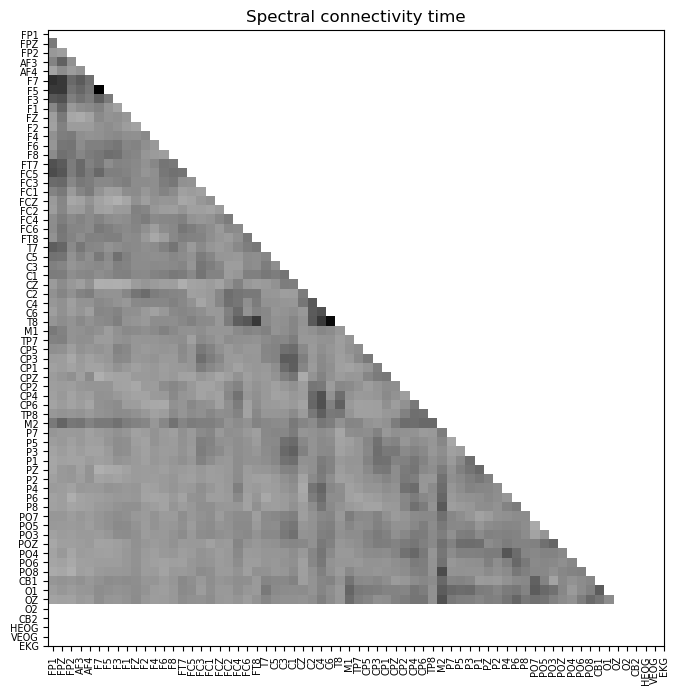

In [59]:
plt.figure(figsize=(8,8))

# if con_time contains 3 data for each freq range of interest: con_plot = plt.imshow(con_time_array[:,:,2], cmap='binary')
con_plot = plt.imshow(con_time_array, cmap='binary')
plt.title('Spectral connectivity time')
plt.xticks(range(len(channel_names)), channel_names, fontsize=7, rotation=90)
plt.yticks(range(len(channel_names)), channel_names, fontsize=7)

plt.show()

### epochs.info

In [61]:
# all-to-all connectivity in sensor space

from mne_connectivity.viz import plot_sensors_connectivity

plot_sensors_connectivity(epochs.info, con_time_array.squeeze())

In [71]:
# envelope correlations in volume source space

from mne.beamformer import apply_lcmv_epochs, make_lcmv
from mne.preprocessing import compute_proj_ecg, compute_proj_eog
from mne_connectivity import envelope_correlation

(67, 67)

In [75]:
stcs = apply_lcmv_epochs(epochs, filters, return_generator=True)
corr = envelope_correlation(stcs, verbose=True)
del stcs, epochs, filters

array([ 0.1  , 12.575, 25.05 , 37.525, 50.   ])

<RawArray | 67 x 248480 (497.0 s), ~127.1 MB, data loaded>